<a href="https://colab.research.google.com/github/gpdsec/Residual-Neural-Network/blob/main/Custom_Residual_Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*It's custom ResNet trained demonstration purpose, not for accuracy.
Dataset used is cats_vs_dogs dataset from tensorflow_dataset with **Custom Augmentatior** for data augmentation*

---


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **1. Importing Libraries**





In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, GlobalMaxPooling2D, Add, ReLU, Layer
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from PIL import Image
from tqdm.notebook import tqdm
import os
import time
%matplotlib inline


### **2. Loading & Processing Data**





##### **Loading Data**

In [3]:
(train_ds, val_ds, test_ds), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete6NUV54/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
## Image preprocessing function
def preprocess(img, lbl):
    image = tf.image.resize_with_pad(img, target_height=224, target_width=224)
    image = tf.divide(image, 255)
    label = [0,0]
    if int(lbl) == 1:
      label[1]=1
    else:
      label[0]=1
    return image, tf.cast(label, tf.float32)

In [5]:
train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)
val_ds = val_ds.map(preprocess)


In [6]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

####  **Data Augmentation layer**





In [7]:
###### Important Variables

batch_size = 32
shape = (224, 224, 3)
training_steps = int(18610/batch_size)
validation_steps = int(2326/batch_size)
path = '/content/drive/MyDrive/Colab Notebooks/cats_v_dogs.h5'  

In [8]:
#######  Data agumentation layer
# RandomFlip and RandomRotation Suits my need for Data Agumentation


augmentation=Sequential([
              layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
              layers.experimental.preprocessing.RandomRotation(0.2),
              ])

####### Data Shuffle and batch Function
def shufle_batch(train_set, val_set, batch_size): 
    train_set=(train_set.shuffle(1000).batch(batch_size))
    train_set = train_set.map(lambda x, y: (augmentation(x, training=True), y))
    val_set = (val_set.shuffle(1000).batch(batch_size))
    val_set = val_set.map(lambda x, y: (augmentation(x, training=True), y))
    return train_set, val_set


train_set, val_set  = shufle_batch(train_ds, val_ds, batch_size)


## **3. Creating Model**

##### **Creating Custom Residual Layer**

In [9]:
# filter=(3,3) , _strides=(1,1), _network_shortcut=False
class ResidualLayer(Layer):
  def __init__(self, feature_map, filters):
    super(ResidualLayer, self).__init__()
    filter, _strides, _network_shortcut = filters
  
    self.conv01 = Conv2D(feature_map, filter, strides=_strides, activation='relu', padding='same')
    self.conv02 = Conv2D(feature_map, filter, strides=_strides, activation='relu', padding='same')
    self.conv03 = Conv2D(feature_map, filter, strides=_strides, activation='relu', padding='same')
    self.BN01 = BatchNormalization()
    self.BN02 = BatchNormalization()
    self.BN03 = BatchNormalization()
    self.shortcut_NW = _network_shortcut
    self.relu = ReLU()
    self.ad = Add()
  
  def call(self, input_tensor):
    shortcut = input_tensor
    x = self.conv01(input_tensor)
    x = self.BN01(x)
    x = self.conv02(x)
    x = self.BN02(x)
    if self.shortcut_NW:
      shortcut = self.conv03(input_tensor)
      shortcut = self.BN03(shortcut)
    x = self.ad([shortcut, x])
    return self.relu(x)
    

In [10]:
# initializing residual lauyer
filters = [(3,3), (1,1), False]
residual_block01 = ResidualLayer(32, filters)
residual_block02 = ResidualLayer(64, filters)

In [11]:
# Build the model using the functional API
i = Input(shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = residual_block01(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = residual_block02(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2, activation='sigmoid')(x)

model = Model(i, x)

In [12]:
#model.compile()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
residual_layer (ResidualLaye (None, 224, 224, 32)      18752     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 112, 112, 64)      256   

### **4. Optimizer and loss Function** 

In [13]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
Optimiser = tf.keras.optimizers.Adam()

### **5. Metrics For Loss and Acuracy**

In [14]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

### **6. Function for training and Testing**

In [15]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    prediction = model(images, training=True)
    loss = loss_object(labels,prediction)
  gradient = tape.gradient(loss, model.trainable_variables)
  Optimiser.apply_gradients(zip(gradient, model.trainable_variables))
  train_loss(loss)
  train_accuracy(labels, prediction)

In [16]:
@tf.function
def test_step(images, labels):
  prediction = model(images, training = False)
  t_loss = loss_object(labels, prediction)
  test_loss(t_loss)
  test_accuracy(labels, prediction)

### **7. Training Model**

In [17]:
EPOCHS = 50
Train_LOSS = []
TRain_Accuracy = []
Test_LOSS = []
Test_Accuracy = [] 

for epoch in range(EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()
  print(f'Epoch : {epoch+1}')

  count = 0  # variable to keep tab how much data steps of training
  desc = "EPOCHS {:0>4d}".format(epoch+1)


  for images, labels in tqdm(train_set, total=training_steps, desc=desc):
    train_step(images, labels)
  
  for test_images, test_labels in val_set:
    test_step(test_images, test_labels)
 
    
    
  

  print(
      f'Loss: {train_loss.result()}, '
      f'Accuracy: {train_accuracy.result()*100}, '
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result()*100}'
  )

  Train_LOSS.append(train_loss.result())
  TRain_Accuracy.append(train_accuracy.result()*100)
  Test_LOSS.append(test_loss.result())
  Test_Accuracy.append(test_accuracy.result()*100)

  ### Saving BestModel

  if epoch==0:
    min_Loss = test_loss.result()
    min_Accuracy = test_accuracy.result()*100
  elif (min_Loss>test_loss.result()):
    if (min_Accuracy <= test_accuracy.result()*100) :
      min_Loss = test_loss.result()
      min_Accuracy = ( test_accuracy.result()*100)
      print(f"Saving Best Model {epoch+1}")
      model.save_weights(path)                            # Saving Model To drive
      

Epoch : 1



Loss: 0.879467785358429, Accuracy: 58.191829681396484, Test Loss: 0.79024338722229, Test Accuracy: 54.44969940185547
Epoch : 2



Loss: 0.628228485584259, Accuracy: 63.91187286376953, Test Loss: 0.5983717441558838, Test Accuracy: 68.61565399169922
Saving Best Model 2
Epoch : 3



Loss: 0.5959568619728088, Accuracy: 68.58140563964844, Test Loss: 0.5763929486274719, Test Accuracy: 68.01375579833984
Epoch : 4



Loss: 0.5523948669433594, Accuracy: 72.84255981445312, Test Loss: 0.5801330804824829, Test Accuracy: 70.39982604980469
Saving Best Model 4
Epoch : 5



Loss: 0.5177363753318787, Accuracy: 75.72003936767578, Test Loss: 0.5585185289382935, Test Accuracy: 71.00172424316406
Saving Best Model 5
Epoch : 6



Loss: 0.47717493772506714, Accuracy: 78.0064468383789, Test Loss: 0.506016194820404, Test Accuracy: 76.05330657958984
Saving Best Model 6
Epoch : 7



Loss: 0.44344666600227356, Accuracy: 80.14239501953125, Test Loss: 0.6688603162765503, Test Accuracy: 63.06964874267578
Epoch : 8



Loss: 0.41576236486434937, Accuracy: 81.88070678710938, Test Loss: 0.4028218984603882, Test Accuracy: 82.9965591430664
Saving Best Model 8
Epoch : 9



Loss: 0.38281312584877014, Accuracy: 83.44706726074219, Test Loss: 0.4050252139568329, Test Accuracy: 82.5451431274414
Epoch : 10



Loss: 0.3612504005432129, Accuracy: 84.54593658447266, Test Loss: 0.3583121597766876, Test Accuracy: 85.03868865966797
Saving Best Model 10
Epoch : 11



Loss: 0.334329754114151, Accuracy: 86.22514343261719, Test Loss: 0.5087668299674988, Test Accuracy: 74.67755889892578
Epoch : 12



Loss: 0.31740427017211914, Accuracy: 86.8887710571289, Test Loss: 0.3011564314365387, Test Accuracy: 87.83319091796875
Saving Best Model 12
Epoch : 13



Loss: 0.29994887113571167, Accuracy: 87.98226928710938, Test Loss: 0.29266443848609924, Test Accuracy: 88.1341323852539
Saving Best Model 13
Epoch : 14



Loss: 0.27937716245651245, Accuracy: 88.70499420166016, Test Loss: 0.302496075630188, Test Accuracy: 87.18830108642578
Epoch : 15



Loss: 0.27156832814216614, Accuracy: 89.29338836669922, Test Loss: 0.3904787003993988, Test Accuracy: 80.82545471191406
Epoch : 16



Loss: 0.25816836953163147, Accuracy: 89.78506469726562, Test Loss: 0.3238995671272278, Test Accuracy: 86.37145233154297
Epoch : 17



Loss: 0.25407007336616516, Accuracy: 90.09403228759766, Test Loss: 0.7080084681510925, Test Accuracy: 71.04471588134766
Epoch : 18



Loss: 0.22745585441589355, Accuracy: 90.7791519165039, Test Loss: 0.23368315398693085, Test Accuracy: 90.02579498291016
Saving Best Model 18
Epoch : 19



Loss: 0.22208000719547272, Accuracy: 91.114990234375, Test Loss: 0.2598656713962555, Test Accuracy: 89.42390441894531
Epoch : 20



Loss: 0.21962310373783112, Accuracy: 91.36486053466797, Test Loss: 0.23532472550868988, Test Accuracy: 89.25193786621094
Epoch : 21



Loss: 0.2117621898651123, Accuracy: 91.88070678710938, Test Loss: 0.21221154928207397, Test Accuracy: 90.5846939086914
Saving Best Model 21
Epoch : 22



Loss: 0.20374080538749695, Accuracy: 92.06609344482422, Test Loss: 0.22823955118656158, Test Accuracy: 90.28375244140625
Epoch : 23



Loss: 0.19339604675769806, Accuracy: 92.40731048583984, Test Loss: 0.1924312263727188, Test Accuracy: 91.42304992675781
Saving Best Model 23
Epoch : 24



Loss: 0.19424636662006378, Accuracy: 92.32939147949219, Test Loss: 0.23731786012649536, Test Accuracy: 90.88563537597656
Epoch : 25



Loss: 0.18338069319725037, Accuracy: 92.89629364013672, Test Loss: 0.22623062133789062, Test Accuracy: 90.84264373779297
Epoch : 26



Loss: 0.17903880774974823, Accuracy: 93.0010757446289, Test Loss: 0.23690403997898102, Test Accuracy: 90.54170227050781
Epoch : 27



Loss: 0.18062318861484528, Accuracy: 92.92584991455078, Test Loss: 0.18647195398807526, Test Accuracy: 92.8202896118164
Saving Best Model 27
Epoch : 28



Loss: 0.16767267882823944, Accuracy: 93.49543762207031, Test Loss: 0.19972842931747437, Test Accuracy: 91.93894958496094
Epoch : 29



Loss: 0.16801491379737854, Accuracy: 93.36915588378906, Test Loss: 0.1639096587896347, Test Accuracy: 93.4866714477539
Saving Best Model 29
Epoch : 30



Loss: 0.16633862257003784, Accuracy: 93.58677673339844, Test Loss: 0.21225257217884064, Test Accuracy: 91.16509246826172
Epoch : 31



Loss: 0.15996304154396057, Accuracy: 93.890380859375, Test Loss: 0.17784518003463745, Test Accuracy: 92.6698226928711
Epoch : 32



Loss: 0.16093342006206512, Accuracy: 93.91456604003906, Test Loss: 0.1771048605442047, Test Accuracy: 92.99226379394531
Epoch : 33



Loss: 0.1550845205783844, Accuracy: 93.91456604003906, Test Loss: 0.17045116424560547, Test Accuracy: 93.22872161865234
Epoch : 34



Loss: 0.14648441970348358, Accuracy: 94.446533203125, Test Loss: 0.20287181437015533, Test Accuracy: 91.7024917602539
Epoch : 35



Loss: 0.1423937976360321, Accuracy: 94.29875946044922, Test Loss: 0.17330022156238556, Test Accuracy: 92.51934814453125
Epoch : 36



Loss: 0.14419110119342804, Accuracy: 94.32025909423828, Test Loss: 0.314574271440506, Test Accuracy: 85.9415283203125
Epoch : 37



Loss: 0.14287008345127106, Accuracy: 94.6749038696289, Test Loss: 0.1487063318490982, Test Accuracy: 93.72312927246094
Saving Best Model 37
Epoch : 38



Loss: 0.13649967312812805, Accuracy: 94.85491180419922, Test Loss: 0.1702130138874054, Test Accuracy: 92.79878997802734
Epoch : 39



Loss: 0.14183475077152252, Accuracy: 94.69640350341797, Test Loss: 0.24307775497436523, Test Accuracy: 90.13327026367188
Epoch : 40



Loss: 0.13392974436283112, Accuracy: 94.81998443603516, Test Loss: 0.14666064083576202, Test Accuracy: 93.78761291503906
Saving Best Model 40
Epoch : 41



Loss: 0.1303890496492386, Accuracy: 94.92745971679688, Test Loss: 0.16302970051765442, Test Accuracy: 93.5296630859375
Epoch : 42



Loss: 0.12960515916347504, Accuracy: 95.0456771850586, Test Loss: 0.16588300466537476, Test Accuracy: 93.42218780517578
Epoch : 43



Loss: 0.1264476478099823, Accuracy: 94.89790344238281, Test Loss: 0.19989626109600067, Test Accuracy: 92.15391540527344
Epoch : 44



Loss: 0.1339665949344635, Accuracy: 95.0403060913086, Test Loss: 0.14141903817653656, Test Accuracy: 94.21753692626953
Saving Best Model 44
Epoch : 45



Loss: 0.12434366345405579, Accuracy: 95.2713623046875, Test Loss: 0.17457592487335205, Test Accuracy: 93.80911254882812
Epoch : 46



Loss: 0.12375984340906143, Accuracy: 95.41107177734375, Test Loss: 0.14375349879264832, Test Accuracy: 94.62596893310547
Epoch : 47



Loss: 0.145289346575737, Accuracy: 94.7232666015625, Test Loss: 0.1654043197631836, Test Accuracy: 93.63714599609375
Epoch : 48



Loss: 0.12013070285320282, Accuracy: 95.29016876220703, Test Loss: 0.15679322183132172, Test Accuracy: 93.72312927246094
Epoch : 49



Loss: 0.11690884083509445, Accuracy: 95.42181396484375, Test Loss: 0.1614774465560913, Test Accuracy: 93.80911254882812
Epoch : 50



Loss: 0.1141953319311142, Accuracy: 95.72810363769531, Test Loss: 0.1259550005197525, Test Accuracy: 95.42132568359375
Saving Best Model 50


### **8. Ploting Loss and Accuracy Per Iteration**

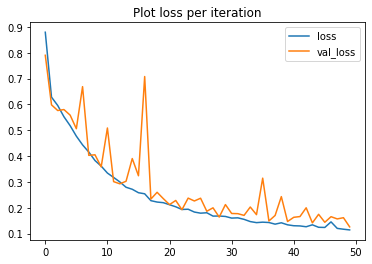

In [18]:
# Plot loss per iteration
plt.plot(Train_LOSS, label='loss')
plt.plot(Test_LOSS, label='val_loss')
plt.title('Plot loss per iteration')
plt.legend()

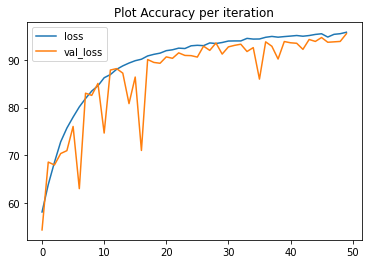

In [19]:
# Plot Accuracy per iteration
plt.plot(TRain_Accuracy, label='loss')
plt.plot(Test_Accuracy, label='val_loss')
plt.title('Plot Accuracy per iteration')
plt.legend()

## 9. Evoluting model

##### **Note-**
Testing Accuracy of Model with Complete Unseen DataSet.

In [20]:
model.load_weights(path)

In [21]:
len(test_ds)

2326

In [22]:
test_set = test_ds.shuffle(50).batch(2326)

In [23]:
for images, labels in test_set:
  prediction = model.predict(images)
  break
## Function For Accuracy
def accuracy(prediction, labels):
    corect =0
    for i in range(len(prediction)):
      pred = prediction[i]
      labe = labels[i]
      if pred[0]>pred[1] and labe[0]>labe[1]:
        corect+=1
      elif pred[0]<pred[1] and labe[0]<labe[1]:
        corect+=1
    
    return (corect/len(prediction))*100
 

In [24]:
print(accuracy(prediction, labels))


95.31384350816853
